In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_pickle('../MIMIC40/data_40_correct.pkl')

ori_patient_feature = dataset[0] #before cleaning, original data
ori_label = dataset[1]
ori_label_time = dataset[2]

In [4]:
len(ori_label), ori_patient_feature[0].shape

(23160, (74, 48))

### Simple Cleaning & train, val, test_split

In [6]:
#outlier removal
list_length = []
for i in range(1,101,1):
    list_length.append(np.percentile(ori_label_time, i))

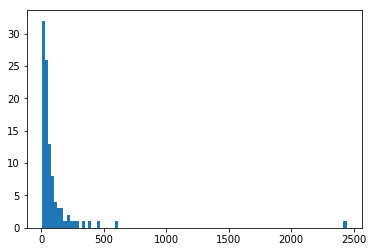

In [7]:
plt.hist(list_length,bins = 100)
plt.show()

In [8]:
keep_idx = np.where(ori_label_time <= list_length[-5])[0]

In [144]:
patient_feature = ori_patient_feature[keep_idx]
label = ori_label[keep_idx]
label_time = ori_label_time[keep_idx]

In [10]:
len(patient_feature)*0.8

17787.2

In [145]:
#split the dataset
idx_arr = list(range(len(patient_feature)))
np.random.shuffle(idx_arr)
patient_feature_train, patient_feature_val, patient_feature_test = \
patient_feature[idx_arr[:15550]],patient_feature[idx_arr[15550:17788]],patient_feature[idx_arr[17788:]]
label_train, label_val, label_test = \
label[idx_arr[:15550]],label[idx_arr[15550:17788]],label[idx_arr[17788:]]
label_time_train, label_time_val, label_time_test = \
label_time[idx_arr[:15550]],label_time[idx_arr[15550:17788]],label_time[idx_arr[17788:]]

In [146]:
len(patient_feature_train)

15550

### Configuration

In [207]:
batch_size = 50
num_epochs = 50

### Helper Function

In [151]:
### Helper function
def block_tri(group_size,scale, num_units, mode):
    '''
    group_size: the size of each group
    num_units: group_size x sum(scale)
    mode: the way of connection, original, shift, fully connect
    return: tensor mask
    '''
    mtrx = np.zeros((num_units, num_units))
    if mode == 'original':
        for i in range(int(num_units/group_size) - 1):
            mtrx[i*group_size: , i*group_size:(i+1)*group_size] = 1
    elif mode == 'shift': 
        mtrx = np.zeros((num_units, num_units))
        for i in range(int(num_units/group_size)):
            refer_li = sum([[i]*i for i in scale],[])
            length = refer_li[i]
            sequence = list(np.arange(i, num_units/group_size))
            #print(sequence)
            sequence = [int(j) for j in sequence if (j - i)%length == 0]
            ##print(sequence)
            for index in sequence:
                mtrx[index*group_size:(index+1)*group_size,i*group_size:(i+1)*group_size] = 1
    return mtrx 

#def activate_index()

def activate_index(timestep, num_units, group_size, scale,index_li,batch_size,input_size = 48):
    '''
    timestep: the current timestep in a sequence
    num_units: dimension of hidden layer
    group_size: number of nodes in each group
    scale: the range of update frequency
    index_li: the index of each scale start point. dictionary. scale: position
    input_size: the feature dim for patient
    return: a matrix with 0 and 1. 1 for active rows seperately for linear layer h and i
    '''
    activation_map = np.zeros((batch_size, num_units))
    for i in scale:
        remain = timestep%i
        if remain == 0:
            index_temp = index_li[i]
            activation_map[:,index_temp*group_size:(index_temp+1)*group_size] = np.ones((batch_size,group_size))
        else:
            index_temp = i - remain + index_li[i]
            activation_map[:, index_temp*group_size:(index_temp+1)*group_size] = np.ones((batch_size,group_size))
    return torch.from_numpy(activation_map).float()
### make it a tensor

def padding_fun(data, labels, label_time):
    '''
    This is going to pad the data in the front.
    data: a batch of patient feature. now, a list (with length as batch_size) of array of T * 48
    labels: a list of zero and one
    return target: padded_data should be batch x 48 x max_length. called in the data loader function (this is different from context window since window has fixed size and can be done before)
           length: original length of each patient records
    '''
    max_length = max(label_time)
    target_data = np.array([np.pad(i,((max_length - len(i),0),(0,0)), 'constant', constant_values = 0) for i in data])
    target_label = np.array([np.pad([labels[i]]*label_time[i],(max_length - label_time[i],0),'constant', constant_values = -1 ) for i in range(len(labels))])
    #padding -1 here, so would be ignored when calculating loss
    #print(data[i].shape)
    target = np.array(data)
    #print(target.shape)#for debug
    return target_data, target_label

In [172]:
#not used for now
def activate_index_second(timestep, num_units, group_size, scale,index_li,batch_size,input_size = 48):
    '''
    timestep: the current timestep in a sequence
    num_units: dimension of hidden layer
    group_size: number of nodes in each group
    scale: the range of update frequency
    index_li: the index of each scale start point. dictionary. scale: position
    input_size: the feature dim for patient
    return: a matrix with 0 and 1. 1 for active rows seperately for linear layer h and i
    '''
    activation_map_h = np.zeros((num_units, num_units))
    activation_map_i = np.zeros((input_size, num_units))
    activation_map_h_re = np.ones(num_units)
    #activation_map_i_re = np.ones(num_units)   

    for i in scale:
        remain = timestep%i
        if remain == 0:
            index_temp = index_li[i]
            activation_map_h[:,index_temp*group_size:(index_temp+1)*group_size] = np.ones((batch_size,group_size))
            activation_map_i[:,index_temp*group_size:(index_temp+1)*group_size] = np.ones((input_size,group_size))
            activation_map_h_re[index_temp*group_size:(index_temp+1)*group_size] = np.zeros(group_size)
            #activation_map_i_re[index_temp*group_size:(index_temp+1)*group_size] = np.zeros(group_size)
        else:
            index_temp = i - remain + index_li[i]
            activation_map_h[:, index_temp*group_size:(index_temp+1)*group_size] = np.ones((batch_size,group_size))
            activation_map_i[:, index_temp*group_size:(index_temp+1)*group_size] = np.ones((batch_size,group_size))
            activation_map_h_re[index_temp*group_size:(index_temp+1)*group_size] = np.zeros(group_size)
            #activation_map_i_re[index_temp*group_size:(index_temp+1)*group_size] = np.zeros(group_size)
    return torch.from_numpy(activation_map_h).float(), torch.from_numpy(activation_map_i).float(),\
torch.from_numpy(activation_map_h_re).float()

In [168]:
a = torch.from_numpy(np.array([[1,2,3],[4,5,6]])).float()
b = torch.from_numpy(np.ones(3)).float()

In [199]:
a = np.array([[1, 2, 3, 4, 5],[5,6,7,8,9]])

In [200]:
a

array([[1, 2, 3, 4, 5],
       [5, 6, 7, 8, 9]])

In [201]:
np.argmax(a, axis = 1)

array([4, 4])

In [ ]:
a = np.array([[1, 2, 3, 4, 5],[1,2,3,4,5]]).T
b = np.array([[1, 2, 3, 4, 5,6],[1,2,3,4,5,7]]).T
c = np.array([[1, 2, 3, 4],[1,2,3,4]]).T

data = [a,b,c]
labels = [1.0,1.0,1.0]
label_time = [5.0, 6.0, 4.0]

In [ ]:
data_, label_ = padding_fun(data, labels, label_time)

In [ ]:
data_[0].shape

In [ ]:
label_

In [ ]:
li

In [ ]:
li = [k[0], k[1], k[2]]
torch.stack(li, dim = 1).view(-1, 6)

In [175]:
target = torch.Tensor([[1.0,1.0],[0.0,0.0],[1.0,1.0]])

In [177]:
target.numpy()

array([[ 1.,  1.],
       [ 0.,  0.],
       [ 1.,  1.]], dtype=float32)

In [ ]:
target.transpose(0,1).contiguous().view(-1)

In [ ]:
torch.stack([torch.Tensor(labels),torch.Tensor(label_time)],dim = 1).view(-1, 3)

### Data Loader

In [122]:
class MIMICDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, label_list, label_time_li):
        """
        @param data_list: list of datapoints, each element is a embedding matrix
        """
        self.data_list = data_list
        self.label_list = label_list
        self.label_time_list = label_time_li
        
    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        return (self.data_list[key], self.label_list[key], self.label_time_list[key])

#training data in this case should be an array of arrays. for each array, it is an array of size T*48 
def MIMIC_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    label_time_list = []
    for data_point in batch:#batch is a list of items(selected by index), each is imdb_train[i]#which is by above get item
        data_list.append(data_point[0])
        label_list.append(data_point[1])
        label_time_list.append(data_point[2])

    #return a batch of padded data
    new_data, label_list = padding_fun(data_list, label_list, label_time_list) #should be batch x max_len x 48    batch x max_length
    return [torch.from_numpy(new_data).float(),torch.from_numpy(np.array(label_list)).long()]

def reload_data(batch_sz):
    '''
    batch_sz: pass in the batch size
    return: data loader
    ##TODO: no test loader has been said yet
    '''        
    #print(len(training_wds))
    mimic_train = MIMICDataset(patient_feature_train, label_train, label_time_train)
    mimic_val = MIMICDataset(patient_feature_val, label_val, label_time_val)
    
    train_loader = torch.utils.data.DataLoader(dataset=mimic_train,batch_size=batch_sz,collate_fn=MIMIC_collate_func,shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=mimic_train,batch_size=batch_sz,collate_fn=MIMIC_collate_func,shuffle=True)
        
    return train_loader, validation_loader

### Model

In [173]:
### Model
#forward
#cell_class, step
class Clock_NN(nn.Module):
    def __init__(self, scale,batch_size, group_size = 1, activation_fun = F.relu, mean = 0, std = 0.1, input_dim = 48,mode = 'shift'):
        super(Clock_NN, self).__init__()
        '''
        scale: the updating frequency, a list. [1,2,4,8,16,32]
        batch_size: the size of batch
        group_size: the number of nodes in each scale, default is 1.
        activation_function
        mean: the mean of Gaussian distribution for initialize weights for hidden layer
        std: the standard devation of the Gaussian distribution for initialize weights for hidden layer
        input_dim: the feature dimension of each time step
        '''
        self.scale = scale
        self.group_size = group_size
        self.batch_size = batch_size
        self.mode = mode
        if mode == 'orginal':
            self.num_units = self.scale*self.group_size
        elif mode == 'shift':
            self.num_units = sum(self.scale)*self.group_size
            
        self.class_dim = 2
        self.input_dim = input_dim
        self.linear_h = nn.Linear(self.num_units,self.num_units)
        self.linear_o = nn.Linear(self.num_units,self.class_dim)
        self.linear_i = nn.Linear(self.input_dim, self.num_units)
        self.activation_fun = activation_fun
        self.connect = torch.from_numpy(block_tri(self.group_size, self.scale, self.num_units, self.mode)).float()
        self.time_step = 0
        self.index_li = {i:i-1 for i in self.scale}
        
        self.initial_weights(mean, std)
        
    def forward(self, sequence, hidden):#depends on what passed for model.train(), to be filled)
        '''
        sequence: batch  x timestep x number_feature matrix
        hidden: should be h0
        '''     
        #sequence = sequence.view(48,-1)when this is only one batch
        hidden_output = []
        length = sequence.size()[1]
        logit = []
        for i in range(1,length+1):
            self.time_step += 1
            #backwards, want discharge/dead time aligns
            #print(sequence[:,:,-i].size())#would be batch*48
            hidden = self.CW_RNN_Cell(sequence[:,-i,:].contiguous(), hidden)
            hidden_output.append(hidden)#become batch_size x hidden_dim
            out = self.linear_o(hidden)
            #print(out.size())#should be batch x time x 2
            logit.append(F.log_softmax(out))
        return hidden_output, logit
            
                
    def CW_RNN_Cell(self, x_input, hidden):
        '''
        x_input: number_feature x batch vector, representing one time stamp
        hidden: output of the last cell, should be hidden_dim(i.e. num_units) x batch
        '''
        activate = activate_index(self.time_step, self.num_units, self.group_size, self.scale,self.index_li,batch_size, self.input_dim)
        activate_re = torch.from_numpy(np.ones((self.batch_size,self.num_units))).float() - activate
        
        #print('activate ' + str(activate.size()))
        #print('activate_re ' + str(activate_re.size()))
        #print('hidden ' + str(hidden.size()))
        #print('connect ' + str(self.connect.size()))
        #print('input ' + str(x_input.size()))
        #print('weight ' + str(self.linear_h.weight.size()))
        #print('weight_type ' + str(type(self.linear_h.weight.data)))
        #create the mask
        #print(self.linear_h.weight.data)
        self.linear_h.weight.data = self.linear_h.weight.data*(self.connect.transpose(0,1))#here needs transpose since previously left multiplication, activate mtrx doesn't need as rewrite and select cols.
        self.linear_i.weight.data = self.linear_i.weight.data
        
        #print(self.linear_h.weight.data)
        #*activate.transpose(0,1)
        hidden_next = self.linear_h(hidden) + self.linear_i(x_input) #should be batch_size x hidden_dim
        hidden_next.data = activate*hidden_next.data + activate_re*hidden.data
        hidden_next = self.activation_fun(hidden_next)
        return hidden_next

    def init_hidden(self):
        h0 = Variable(torch.zeros(self.batch_size,self.num_units))
        return h0
        
    def initial_weights(self, mean, std):
        lin_layers = [self.linear_h, self.linear_o, self.linear_i]
        for layer in lin_layers:
            layer.weight.data.normal_(mean, std**2)
            layer.bias.data.fill_(0)
    

In [221]:
def evaluation(data_loader, model):
    '''
    to be filled. use loader for easy call for summarizing training acc
    '''
    pre = []
    labels = []
    model.eval()
    
    for data, label in data_loader:
        data, label = Variable(data), Variable(label)
        #label_scores = model(data, label) #I guess should be a mtrx, batch*class_num?
    
        hidden= model.init_hidden()
        hidden, output = model(data, hidden)

        #now get a list of hidden and a list of outputs
        label = label.transpose(0,1).contiguous().view(-1).data.numpy()
        output = torch.stack(output, dim=1).view(-1, 2).data.numpy()
        keep_idx = np.where(label != -1)[0]
        label_new = list(label[keep_idx])
        output_new = list(np.argmax(np.array(output[keep_idx]),axis = 1))
        pre.extend(output_new)
        labels.extend(label_new)
        #print(len(label_new))
        #print(label_new[20])
        #print(output_new[20])
        
    #print(len(labels) == len(pre))
    acc = sum(np.array(labels) == np.array(pre))/len(labels)
    model.train()
    return acc

In [ ]:
### Training
model = Clock_NN([1,2,4], batch_size, group_size = 1, activation_fun = F.relu, mean = 0, std = 0.1, input_dim = 48)

loss = torch.nn.CrossEntropyLoss(ignore_index=-1)  
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
accuracy_list = []
train_loader, validation_loader = reload_data(batch_size)
for epoch in range(num_epochs):
    for step, (data, label) in enumerate(train_loader):        
        data, label = Variable(data), Variable(label)
        model.zero_grad()
        hidden= model.init_hidden()
        hidden, output = model(data, hidden)
        
        #now get a list of hidden and a list of outputs
        label = label.transpose(0,1).contiguous().view(-1) 
        #should be flatten, batch_size x hidden. transpose due to below order, was batch, seq => follow up 2 down. get size batch*seq
        output = torch.stack(output, dim=1).view(-1, 2) 
        #since batch is the first dimension, so dim is 1. now the order is  seq_len,batch, 2, so the first dimension is the first time step over all batch
        #print(output.size())
        #print(label.size())
        lossy = loss(output, label)
        lossy.backward()
        optimizer.step()
        
        if step % 20 == 0:
            print("Epoch: {}; Loss: {}".format(epoch, lossy.data[0]))
            #print('accuracy_on_training: {}'.format(evaluation(train_loader))) 
            val_acc = evaluation(validation_loader, model)
            print('accuracy_on_validation: {}'.format(val_acc)) 
            accuracy_list.append(val_acc)
            if ((epoch > 5) and ((accuracy_list[-1] < (accuracy_list[-2] - 0.01)) or (accuracy_list[-1] < (accuracy_list[-3] - 0.01)))):
                print("early stop, accuracy = ", accuracy_list[-2])
                break
              

Epoch: 0; Loss: 0.6914035677909851


### Test Field

In [ ]:
activate_index(7,14,2,[1,2,4],{1:0,2:1,4:3})

a = torch.from_numpy(np.array([[1,2,3],[4,5,6]]))
b = torch.from_numpy(np.array([[2,3,4],[4,5,6]]))
c = a*b

c

c[-2,]

In [ ]:
patient_feature[0]

tryme2 = np.ones((5,4))

tryme2

tryme2[[2:4, ],2] = 0

a = np.tril(np.ones((3,3))*(np.array([1,2,3]).reshape(3,1))).flatten()
a[np.nonzero(a)]

x = [[i]*i for i in [1,2,4]]

x = sum(x,[])

x

4%3

In [ ]:
mtrx

block_tri(2,[1,2,4],14, mode = 'shift') == mtrx

In [ ]:
group = 2
unit = 14
mtrx = np.zeros((unit, unit))
for i in range(int(unit/group)):
    sequence = list(np.arange(i, unit/group))
    #print(sequence)
    sequence = [int(j) for j in sequence if (j - i)%x[i] == 0]
    ##print(sequence)
    for index in sequence:
        mtrx[index*group:(index+1)*group,i*group:(i+1)*group] = 1

In [ ]:
patient_feature = dataset[0]
label = dataset[1]

In [ ]:
label_sample.shape

In [ ]:
label_sample

In [ ]:
for i in list(sample):
    print(i.shape)

In [ ]:
sample_tensor = Variable(torch.from_numpy(sample[0]).float())
target_tensor = Variable(torch.from_numpy(label_sample[0]).float())

In [ ]:
sample_tensor.data.shape